## RFM Segmentation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta




C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data= pd.read_csv("../data/cleaned_bank_data.csv")

In [3]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,TransactionDateTime,CustomerAge
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,2016-08-02 14:32:07,31.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,2016-08-02 14:18:58,68.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,2016-08-02 14:27:12,28.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,2016-08-02 14:27:14,52.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,2016-08-02 18:11:56,37.0


#### 1. RFM Base

In [4]:



# --- Dates ---
data["TransactionDate"] = pd.to_datetime(data["TransactionDate"], errors="coerce")
data["CustomerDOB"] = pd.to_datetime(data["CustomerDOB"], errors="coerce")
data["TransactionDateTime"] = pd.to_datetime(data["TransactionDateTime"], errors="coerce")

# --- RFM base (valid rows only) ---
rfm_base = (
    data.dropna(subset=["CustomerID", "TransactionDate", "TransactionAmount"])
      .query("`TransactionAmount` >= 0")
      .copy()
)




###### The goal here is to set to datetime and create a reliable “transaction base” — a clean subset of your dataset that contains only valid, usable transactions for RFM analysis.

- Remember:

- R (Recency) is based on TransactionDate

- F (Frequency) depends on CustomerID

- M (Monetary) comes from TransactionAmount

- So this step ensures these three variables are all valid and present for each record.

- df.dropna(subset=["CustomerID", "TransactionDate", "TransactionAmount"]) here removes any rows where CustomerID, TransactionDate, or TransactionAmount is missing (NaN).

#### 2. Compute RFM features (with snapshot date)

In [5]:
# Snapshot date: 1 day after the latest transaction in the modeling window
snapshot_date = rfm_base["TransactionDate"].max() + timedelta(days=1)

# Aggregate per customer
rfm_pre = (
    rfm_base.groupby("CustomerID", as_index=False)
            .agg(
                LastTxnDate=("TransactionDate", "max"),
                FirstTxnDate=("TransactionDate", "min"),
                Frequency=("TransactionID", "nunique"), 
                Monetary=("TransactionAmount", "sum"),
                AvgTxnAmt=("TransactionAmount", "mean")
            )
)

# Recency in days
rfm_pre["RecencyDays"] = (snapshot_date - rfm_pre["LastTxnDate"]).dt.days

# sanity prints
print("Customers in RFM base:", len(rfm_pre))
print("Snapshot date:", snapshot_date.date())
print(rfm_pre[["CustomerID","RecencyDays","Frequency","Monetary"]].head())


Customers in RFM base: 838539
Snapshot date: 2016-10-22
  CustomerID  RecencyDays  Frequency  Monetary
0   C1010011           26          2    5106.0
1   C1010012           69          1    1499.0
2   C1010014           76          2    1455.0
3   C1010018           37          1      30.0
4   C1010024           65          1    5000.0


In [6]:
rfm_pre.head()

,CustomerID,LastTxnDate,FirstTxnDate,Frequency,Monetary,AvgTxnAmt,RecencyDays
0,C1010011,2016-09-26,2016-08-09,2,5106.0,2553.0,26
1,C1010012,2016-08-14,2016-08-14,1,1499.0,1499.0,69
2,C1010014,2016-08-07,2016-08-01,2,1455.0,727.5,76
3,C1010018,2016-09-15,2016-09-15,1,30.0,30.0,37
4,C1010024,2016-08-18,2016-08-18,1,5000.0,5000.0,65


#### 3. Assign 1–5 R, F, M scores (quintiles with safe fallback)

In [7]:
def safe_qcut_rank(series, ascending=True):
    # Rank then qcut to handle ties / duplicate values robustly
    ranks = series.rank(method="first")
    uniq = ranks.nunique()
    bins = min(5, int(uniq)) if uniq > 0 else 1
    labels = list(range(1, bins+1))
    q = pd.qcut(ranks, q=bins, labels=labels, duplicates="drop").astype(int)
    if bins < 5:
        # Scale to 1..5 when less than 5 bins exist
        if q.max() != q.min():
            q = ((q - q.min()) / (q.max() - q.min()) * 4 + 1).round().astype(int)
        else:
            q = pd.Series([3]*len(q), index=q.index)
    return q if ascending else (6 - q)

# Lower recency is better → invert
rfm_pre["R_Score"] = safe_qcut_rank(rfm_pre["RecencyDays"], ascending=False)
rfm_pre["F_Score"] = safe_qcut_rank(rfm_pre["Frequency"],   ascending=True)
rfm_pre["M_Score"] = safe_qcut_rank(rfm_pre["Monetary"],    ascending=True)

# 3-digit score like 545 (R=5,F=4,M=5)
rfm_pre["RFM_Score"] = rfm_pre["R_Score"]*100 + rfm_pre["F_Score"]*10 + rfm_pre["M_Score"]


In [8]:
rfm_pre

,CustomerID,LastTxnDate,FirstTxnDate,Frequency,Monetary,AvgTxnAmt,RecencyDays,R_Score,F_Score,M_Score,RFM_Score
0,C1010011,2016-09-26,2016-08-09,2,5106.0,2553.0,26,5,5,5,555
1,C1010012,2016-08-14,2016-08-14,1,1499.0,1499.0,69,2,1,4,214
2,C1010014,2016-08-07,2016-08-01,2,1455.0,727.5,76,1,5,4,154
3,C1010018,2016-09-15,2016-09-15,1,30.0,30.0,37,5,1,1,511
4,C1010024,2016-08-18,2016-08-18,1,5000.0,5000.0,65,2,1,5,215
...,...,...,...,...,...,...,...,...,...,...,...
838534,C9099836,2016-08-07,2016-08-07,1,691.0,691.0,76,1,5,3,153
838535,C9099877,2016-09-15,2016-09-15,1,222.0,222.0,37,5,5,2,552
838536,C9099919,2016-08-18,2016-08-18,1,126.0,126.0,65,2,5,1,251
838537,C9099941,2016-08-28,2016-08-28,1,50.0,50.0,55,3,5,1,351


##### 4. Map scores to business segments

In [9]:


def map_segments(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]

    # 1) Champions: very recent & very active
    if r >= 4 and f >= 4:
        return "Champions"

    # 2) Loyal: active and valuable even if not ultra-recent (but not Champions)
    if f >= 4 and m >= 3:
        return "Loyal"

    # 3) Promising: recent but still building frequency/value (but not above)
    if r >= 4 and (f >= 2 or m >= 2):
        return "Promising"

    # 4) At Risk: stale but historically good activity/value
    if r <= 2 and (f >= 3 or m >= 3):
        return "At Risk"

    # 5) Others: everything else (incl. previously “Hibernating”)
    return "Others"

rfm_pre["Segment"] = rfm_pre.apply(map_segments, axis=1)


In [10]:
rfm_pre

,CustomerID,LastTxnDate,FirstTxnDate,Frequency,Monetary,AvgTxnAmt,RecencyDays,R_Score,F_Score,M_Score,RFM_Score,Segment
0,C1010011,2016-09-26,2016-08-09,2,5106.0,2553.0,26,5,5,5,555,Champions
1,C1010012,2016-08-14,2016-08-14,1,1499.0,1499.0,69,2,1,4,214,At Risk
2,C1010014,2016-08-07,2016-08-01,2,1455.0,727.5,76,1,5,4,154,Loyal
3,C1010018,2016-09-15,2016-09-15,1,30.0,30.0,37,5,1,1,511,Others
4,C1010024,2016-08-18,2016-08-18,1,5000.0,5000.0,65,2,1,5,215,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...
838534,C9099836,2016-08-07,2016-08-07,1,691.0,691.0,76,1,5,3,153,Loyal
838535,C9099877,2016-09-15,2016-09-15,1,222.0,222.0,37,5,5,2,552,Champions
838536,C9099919,2016-08-18,2016-08-18,1,126.0,126.0,65,2,5,1,251,At Risk
838537,C9099941,2016-08-28,2016-08-28,1,50.0,50.0,55,3,5,1,351,Others


##### 5.Segment Profiles

In [11]:
profiles = (
    rfm_pre.groupby("Segment")
       .agg(
           customers=("CustomerID", "count"),
           avg_recency=("RecencyDays", "mean"),
           avg_frequency=("Frequency", "mean"),
           avg_monetary=("Monetary", "mean")
       )
       .round(2)
       .sort_values("customers", ascending=False)
)

profiles


,customers,avg_recency,avg_frequency,avg_monetary
Segment,,,,
Others,201115,60.26,1.02,772.80
At Risk,199595,72.12,1.01,1603.36
Promising,168856,41.31,1.00,1562.41
Champions,152042,40.65,1.60,2342.32
Loyal,116931,65.26,1.41,2860.35


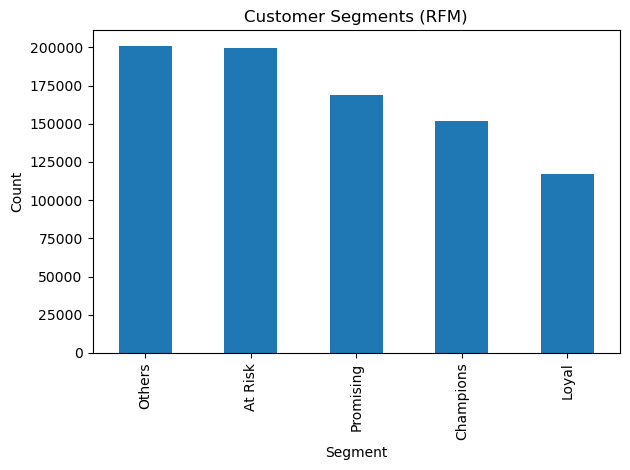

In [12]:
seg_counts = rfm_pre["Segment"].value_counts().sort_values(ascending=False)

plt.figure()
seg_counts.plot(kind="bar")
plt.title("Customer Segments (RFM)")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("rfm_segment_counts.png")
plt.show()


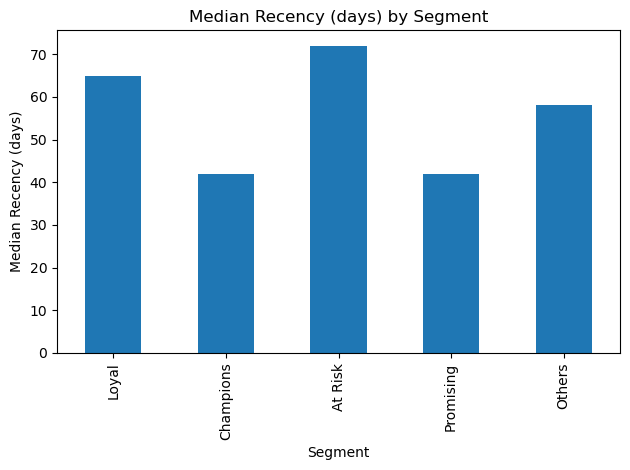

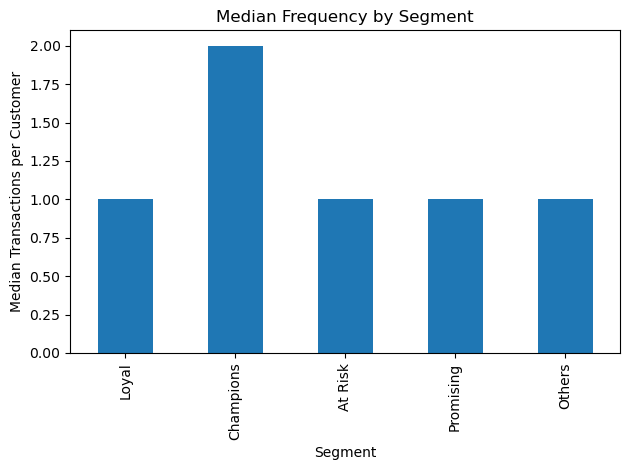

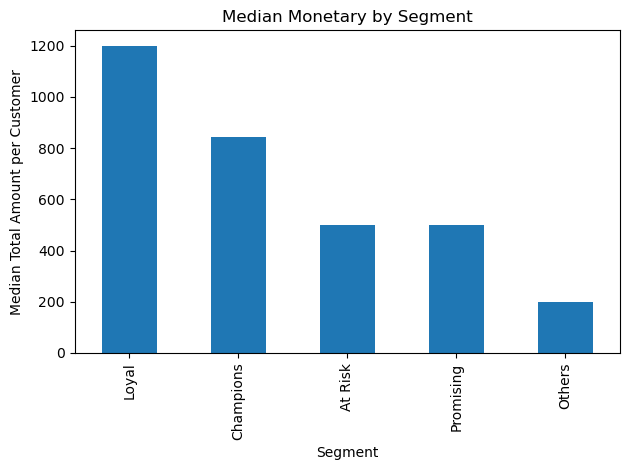

In [13]:
seg_profile = (
    rfm_pre.groupby("Segment")[["RecencyDays","Frequency","Monetary"]]
           .median()
           .sort_values("Monetary", ascending=False)
)

# Median Recency by Segment (lower is better)
plt.figure()
seg_profile["RecencyDays"].plot(kind="bar")
plt.title("Median Recency (days) by Segment")
plt.xlabel("Segment")
plt.ylabel("Median Recency (days)")
plt.tight_layout()
plt.savefig("rfm_segment_median_recency.png")
plt.show()

# Median Frequency by Segment
plt.figure()
seg_profile["Frequency"].plot(kind="bar")
plt.title("Median Frequency by Segment")
plt.xlabel("Segment")
plt.ylabel("Median Transactions per Customer")
plt.tight_layout()
plt.savefig("rfm_segment_median_frequency.png")
plt.show()

# Median Monetary by Segment
plt.figure()
seg_profile["Monetary"].plot(kind="bar")
plt.title("Median Monetary by Segment")
plt.xlabel("Segment")
plt.ylabel("Median Total Amount per Customer")
plt.tight_layout()
plt.savefig("rfm_segment_median_monetary.png")
plt.show()


In [14]:
rfm_scores = (rfm_pre[["CustomerID","RecencyDays","Frequency","Monetary","RecencyDays","R_Score","F_Score", "M_Score", "RFM_Score","Segment"]])

In [15]:
rfm_scores

,CustomerID,RecencyDays,Frequency,Monetary,RecencyDays,R_Score,F_Score,M_Score,RFM_Score,Segment
0,C1010011,26,2,5106.0,26,5,5,5,555,Champions
1,C1010012,69,1,1499.0,69,2,1,4,214,At Risk
2,C1010014,76,2,1455.0,76,1,5,4,154,Loyal
3,C1010018,37,1,30.0,37,5,1,1,511,Others
4,C1010024,65,1,5000.0,65,2,1,5,215,At Risk
...,...,...,...,...,...,...,...,...,...,...
838534,C9099836,76,1,691.0,76,1,5,3,153,Loyal
838535,C9099877,37,1,222.0,37,5,5,2,552,Champions
838536,C9099919,65,1,126.0,65,2,5,1,251,At Risk
838537,C9099941,55,1,50.0,55,3,5,1,351,Others


In [16]:
#rfm_scores.to_csv("rfm_scores.csv", index=False)